# Johdanto
Ylen avointa vaalikone-dataa on jo tutkittu jonkin verran, esimerkiksi klusteroimalla ehdokkaita vastausten perusteella (linkit [tässä](http://users.aalto.fi/~leinona1/vaalit2015/) ja [tässä](http://blogs.helsinki.fi/niemivir/?p=293)). Löytämissäni analyysiessä oltiin ennen kaikkea keskitytty ordinaalisella asteikolla arvosteltujen kysymysten analyysiin. Tässä notebookissa tarkoituksenani on tutkia Ylen vaalikoneen avoimien kysymyksien vastauksia, ja tehdä tilastollista analyysiä sen pohjalta. Samalla tarkoituksena on kokeilla Pythonin text mining-ominaisuuksia suomen kielen analysoinnissa. Lisäksi päästään kokeilemaan Githubin uutta Jupyter-notebook-renderingiä.

# Kirjastot

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re
from langdetect import detect
import string
from nltk import word_tokenize          
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
#notebook-asetukset
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#Datan lukeminen

Data ladattiin .csv-muodossa [täältä](https://www.avoindata.fi/data/fi/dataset/eduskuntavaalien-2015-ylen-vaalikoneen-vastaukset-ja-ehdokkaiden-taustatiedot). Datan alkuperäinen julkaisija ja kerääjä on [Yle](http://yle.fi/uutiset/yle_julkaisee_vaalikoneen_vastaukset_avoimena_datana/7869597). 

Lataamaani .csv-tiedostoon oli yhteen vastaukseen eksynyt merkki jota ei pystynyt enkoodaamaan utf-8-muotoon (tarkemmat tiedot: merkki = 伋, vastaaja Raimo Piirainen, vastausid 4798, rivi 1358). Tämä merkki poistettiin datasta käsin. Tiedostonimellä `data/vaalikone_data_fix.csv` viitataan jatkossa korjattuun versioon tiedostosta.

Alkuun poimittiin tiedostosta avoimia vastauksia sisältävät sarakkeet. Tätä varten luettiin kaksi ensimmäistä riviä datasta, eli header sekä ensimmäinen datarivi:

In [2]:
df_cols = pd.read_csv("data/vaalikone_data_fix.csv", sep = ";", encoding = "utf-8", nrows = 2)
#df_cols = pd.read_csv("data/vastauksetavoimenadatana.csv", sep = ";", encoding = "utf-8", nrows = 2) #korjaamaton data
columns = list(df_cols.columns)

Regexeillä poimittiin sarakkeista ne jotka sisältävät vastauksia avoimiin kysymyksiin. Avoimia kysymyksiä on kahdenlaisia: ehdokkaan ydinsanoman sisältävät kysymykset (Miksi juuri sinut kannattaisi valita/Mitä asioita haluat/Vaalilupaukset) sekä ordinaaliasteikolla vastattaviin kysymyksiin liittyvät avoimet kommentit. Lisäksi poimittiin mukaan ehdokkaiden perustiedot (id, sukunimi, etunimi, puolue).

In [3]:
#regex for the text fields without pipe characters
regex_text = re.compile(("Miksi juuri sinut kannattaisi valita|"
                         "Mitä asioita haluat edistää|"
                         "Vaalilupaus"))
text = filter(regex_text.match, columns)
comments = filter(re.compile("kommentti").search, columns)
text_columns = text + comments
basic_columns = ["id", "sukunimi", "etunimi", "puolue"]

Data luettiin kahteen dataframeen. Yhteen poimittiin tekstidata (`df_text`) ja toiseen perustiedot (`df`):

In [4]:
df_text = pd.read_csv("data/vaalikone_data_fix.csv", sep = ";", encoding = "utf-8", usecols = text_columns)
df = pd.read_csv("data/vaalikone_data_fix.csv", sep = ";", encoding = "utf-8", usecols = basic_columns)

Huom! Mikäli halutaan käyttää suoraan avoindata.fi-sivulta ladattua dataa (eikä korjattua versiota), pitää jättää tuo ongelmallinen rivi pois, muuten parseri heittää errorin:

In [5]:
#df_text = pd.read_csv("data/vastauksetavoimenadatana1.csv", sep = ";", encoding = "utf-8", usecols = text_columns, skiprows = [1357])
#df = pd.read_csv("data/vastauksetavoimenadatana1.csv", sep = ";", encoding = "utf-8", usecols = basic_columns, skiprows = [1357])

# Datan käsittely
Tekstikentät yhdistettiin kaikki yhteen pötköön. Loppupeleissä käyttämämme tekstin representaatio on bag-of-words-tyylinen (tai tarkemmin sanottuna bag-of-ngrams), joten kaikki tekstikentät voinee huoletta koota yhdeksi tajunnanvirraksi. Tekstipötköjä tehtiin kuitenkin kahdenlaisia, yhteen otettiin vain edellämainitut "ydinsanomaan" liittyvät avoimet kysymykset, ja toiseen lisättiin vielä perään kaikki muutkin avoimet kommentit

In [6]:
for i, col in enumerate(text):
    if i == 0:
        series_lesstext = df_text[col].fillna("")
    else:
        series_lesstext = series_lesstext + " " + df_text[col].fillna("")
series_moretext = series_lesstext.copy()
for col in comments:
    series_moretext = series_moretext + " " + df_text[col].fillna("")
series_lesstext = series_lesstext.str.strip()
series_moretext = series_moretext.str.strip()

Lyhyelle tekstinpätkälle annettiin sarakenimeksi `Short_text` ja pidemmälle tekstille nimeksi `Long_text`.

In [7]:
df["Short_text"] = series_lesstext
df["Long_text"] = series_moretext
df.head()

,id,sukunimi,etunimi,puolue,Short_text,Long_text
0,4844,Aalto,Airi,Perussuomalaiset,Perehdyn huolella asioihin ja olen joukkuepela...,Perehdyn huolella asioihin ja olen joukkuepela...
1,5750,Aalto,Esa,Vihreä liitto,Eduskuntaan tarvitaan nyt vahvaa luonnon- ja y...,Eduskuntaan tarvitaan nyt vahvaa luonnon- ja y...
2,5535,Aalto,Harri,Vasemmistoliitto,Olen tunnollinen ja uusia asioita tutkiva ihmi...,Olen tunnollinen ja uusia asioita tutkiva ihmi...
3,4706,Aalto,Matti,Suomen Kommunistinen Puolue,Suomen itsenäisyyden ja sotilaallisen liittout...,Suomen itsenäisyyden ja sotilaallisen liittout...
4,5190,Aalto,Pirkka,Suomen Kristillisdemokraatit (KD),"Minusta Lappi saisi aktiivisen, näkyvän ja kuu...","Minusta Lappi saisi aktiivisen, näkyvän ja kuu..."


Nyt datassamme on kuusi saraketta: id, sukunimi, etunimi, puolue, Short_text ja Long_text.

Tässä vaiheessa huomasin että datasta löytyy jokunen ruotsiksi vastannut ehdokas. Tällaiset tapaukset ovat oletettavasti RKP:n ehdokkaita, ja tekevät mallinnustehtävän vähän turhan helpoksi. Käyttämällä Pythonin `langdetect`-kirjaston `detect`-funktiota, etsimme jokaiselle ei-tyhjälle `Long_text`-havainnolle kielen.

In [8]:
Lang = []
for i in range(len(df.index)):
    if df["Long_text"][i] == "":
        Lang.append(u"Missing")
    else:
        Lang.append(detect(df["Long_text"][i]))
df["Lang"] = Lang
df.Lang.value_counts()

fi         1815
Missing     156
sv           27
dtype: int64

Ruotsinkielisiä vastauksia oli siis 28, ja täysin tyhjiä vastauksia 156. Otetaan mukaan ainoastaan suomenkieliset vastaukset.

In [9]:
df = df[df.Lang == u"fi"]

Viimeisenä esikäsittelyaskeleena jätettiin datasta pikkupuolueet pois. Ajatuksena oli, että näin tilastollisilla malleilla olisi tarpeeksi havaintoja jonkinlaisen rakenteen löytämiseksi. Havaintojen etsimiseksi käytettiin regexejä ja pandas-kirjaston `str.contains`-funktiota.

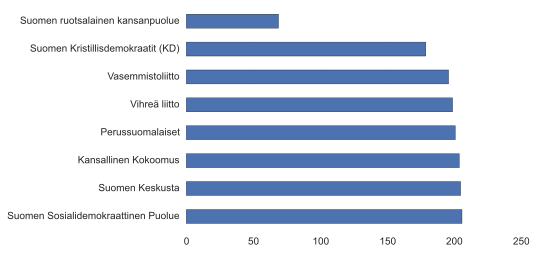

In [10]:
Suuret = ("Perussuomalaiset|Vihre|Vasemmistoliitto|Kristillisdemokraatit|"
         "Suomen ruotsalainen kansanpuolue|Kansallinen Kokoomus|Suomen Sosialidemokraattinen Puolue|"
         "Suomen Keskusta")
df = df[df.puolue.str.contains(Suuret)]
df.puolue.value_counts().plot(kind = "barh");

RKP:tä lukuunottamatta puolueilla on suunnilleen 200 ehdokasta per puolue (KD-ehdokkaita hitusen vähemmän). Kun ruotsinkieliset vastaukset poistettiin aineistosta, jäi sen sijaan jäljelle vain kuutisenkymmentä RKP:n vastausta (mikä taitaa olla vähemmän kuin joidenkin "pikkupuolueiden" havaintojen määrät). Pidetään nyt kuitenkin tämä puoluevalikoima, vaikkakin RKP:n ehdokkaita on aineistossa selvästi vähemmän.

#Tekstinkäsittely
Datan esikäsittelyn jälkeen pitää vielä muuntaa tekstidata muotoon jota tilastollinen algoritmi voi "ymmärtää". Tähän tarkoitukseen käytettiin Pythonin `nltk`- ja `scikit-learn`-kirjastoja.

Ilahduttavasti `nltk`-kirjastosta löytyi suomenkielinen tokenizer, stemmer ja myös täytesanojen lista. Tokenizer määrää sen miten tekstinpätkä jaetaan osasanoihin kun taas stemmer muuntaa eri käännösmuodoissa olevat sanat samaan muotoon. Esimerkiksi sekä `edeltäjiinsä` että `edeltäjistään` stemmataan muotoon `edeltäj`. Tarkempi kuvaus `nltk`-kirjaston suomenkielisestä stemmeristä löytyy [täältä](http://snowball.tartarus.org/algorithms/finnish/stemmer.html). Täytesanalista taas määrittelee sellaiset täytesanat jotka eivät oikeastaan kerro sisällöstä mitään ja jotka on syytä jättää analyyseistä pois (esim. sanat ja, sekä).

Scikit-learn-kirjastosta käytettiin n.s. `TfidfVectorizer`-luokkaa. Tfidf-metodi perustuu eri sanojen (tai n-grammien) esiintymistiheyksien laskemiseen. Eri sanoja painotetaan sitten niin, että harvemmin esiintyvillä sanoilla on korkeampi painoarvo kuin lähes joka dokumentissa esiintyvillä sanoilla. Tarkempi kuvaus löytyy [täältä](http://scikit-learn.org/stable/modules/feature_extraction.html).

`nltk`- ja `scikit-learn`-kirjastojen toimintojen yhdistämisessä auttoi [tämä](http://stackoverflow.com/questions/26126442/combining-text-stemming-and-removal-of-punctuation-in-nltk-and-scikit-learn) Stack Overflow-postaus. Määriteltiin `tokenize`-funktio joka kutsuu `nltk`:n tokenizeria ja `stem_tokens`-funktiota joka taas kutsuu `nltk`:n suomenkielistä stemmeria. Täten määritelty `tokenize`-funktio voidaan sitten syöttää parametrina `TfidfVectorizer`-luokan konstruktorille, kuten myös täytesanojen lista. 

Ngrammien pituuden vaihteluväliksi määrättiin (1,3), eli pisimmillään bag-of-words-representaatioon otetaan mukaan kolmen sanan mittaisia ngrammeja. Parametrin `min_df` arvoksi asetettiin 5, mikä tarkoittaa että jonkun ngrammin pitää löytyä aineistosta vähintään viisi kertaa jotta se tulee mukaan analyysimatriisiin. Parametrin `max_df` arvoksi taas asetettiin 0.9, mikä tarkoittaa sitä, että sanat jotkat esiintyvät useammassa kuin 90%:ssa aineistosta eivät tule mukaan analyysimatriisiin.

In [11]:
#http://stackoverflow.com/questions/26126442/combining-text-stemming-and-removal-of-punctuation-in-nltk-and-scikit-learn
stemmer = SnowballStemmer("finnish")
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = word_tokenize(text, language = "finnish")
    stems = stem_tokens(tokens, stemmer)
    return stems

`TfidfVectorizeria` käyttämällä pitkälle ja lyhyelle tekstipätkälle laskettiin omat sparse-matriisit (x_tfidf_short ja x_tfidf_long). Tokenizer/stemmer-yhdistelmämme ei vaikuta olevan kovin nopea, joten alla olevan koodinpätkän ajamiseen menee minuutti/pari.

In [12]:
vect_long = TfidfVectorizer(ngram_range = (1, 3), min_df = 5, max_df = 0.9,
                       tokenizer=tokenize, stop_words=stopwords.words("finnish"))
x_tfidf_long = df["Long_text"].values
x_tfidf_long = vect_long.fit_transform(x_tfidf_long)
names_long = vect_long.get_feature_names()

vect_short = TfidfVectorizer(ngram_range = (1, 3), min_df = 5, max_df = 0.9,
                       tokenizer=tokenize, stop_words=stopwords.words("finnish"))
x_tfidf_short = df["Short_text"].values
x_tfidf_short = vect_short.fit_transform(x_tfidf_short)
names_short = vect_short.get_feature_names()

#Mallinnus
Tilastolliseksi malliksi valitsimme mahdollisimman yksinkertaisen luokittelumallin eli logistisen regression. Syitä ovat `scikit-learnin` `LogisticRegression`-implementaation tuki sparse-matriiseille (joita `x_tfidf_short` ja `x_tfidf_long` ovat), mallin tulkinnan helppous regressiokertoimien avulla ja se, että mallista saa suoraan irti luokittelutodennäköisyyksiä.

Päätimme määritellä luokitteluongelman "one-vs-all"-tyylisesti. Määrittelemme siis jokaiselle puolueelle oman luokitteluongelman jossa tavoitteena on luokitella havainnot juuri tuohon kyseiseen puolueeseen kuuluviin sekä muihin puolueisiin kuuluviin. Valitsimme tämänlaisen formulaation sen takia, että voitaisiin vertailla eri puolueisiin luokittelun vaikeutta, ja jotta saataisiin regressiokertoimet laskettua puoluekohtaisesti.

Seuraavassa tutkitaan miten hyvin logistinen regressiomalli suoriutuu havaintojen luokittelusta eri puolueille. Lisäksi tutkitaan sitä, miten paljon mallin suorituskyky muuttuu kun siirrytään lyhyestä, ydinsanoman sisältävästä tekstistä pitempään tekstiin jossa on vapaat kommentitkin mukana.

Mallin suorituskykymittarina käytetään n.s. receiver operating characteristic-käyrän (ROC) alle jäävää pinta-alaa (ROC-AUC). Tämä mitta on hyvinkin yleisessä käytössä kun arvioidaan binäärisen luokittelumallin luokittelutodennäköisyyksien laatua. Tarkempi selitys mittarista löytyy [täältä](http://en.wikipedia.org/wiki/Receiver_operating_characteristic). Tulkinnan kannalta oleellisinta on tietää että surempi ROC-AUC on parempi, ja että ROC-AUC-arvo 0.5 vastaa täysin satunnaista arvausta.

Seuraavassa koodinpätkässä lasketaan jokaiselle puolueelle ja molemmille tekstityypeille ristikkäisvalidoidut ROC-AUC-arvot ja tallennetaan ne dataframeen.

In [13]:
clf = LogisticRegression(random_state = 42)
suuret = df.puolue.unique()
df_models = pd.DataFrame(columns = ("puolue", "roc_auc_short_text", "roc_auc_long_text"))
i = 0
for puolue in suuret:
    y = (df.puolue.values == puolue).astype(int)
    roc_short = cross_val_score(clf, x_tfidf_short, y, scoring = "roc_auc", cv = 4).mean()
    roc_long = cross_val_score(clf, x_tfidf_long, y, scoring = "roc_auc", cv = 4).mean()
    df_models.loc[i] = [puolue, roc_short, roc_long]
    i += 1
df_models.sort(["roc_auc_long_text"], ascending = False)

,puolue,roc_auc_short_text,roc_auc_long_text
2,Vasemmistoliitto,0.784122,0.912407
5,Kansallinen Kokoomus,0.754346,0.908659
3,Suomen Kristillisdemokraatit (KD),0.768966,0.886781
0,Perussuomalaiset,0.784438,0.869967
6,Suomen Sosialidemokraattinen Puolue,0.717511,0.844308
1,Vihreä liitto,0.850075,0.842295
7,Suomen Keskusta,0.708061,0.841188
4,Suomen ruotsalainen kansanpuolue,0.731819,0.829353


Huomataan, että lyhyen ja pitkän tekstin välillä on suuret erot pitkän tekstin hyväksi, paitsi Vihreiden tapauksessa. Pelkän ydinsanoman perusteella ei siis mitenkään virheettömästi pystytä ennustamaan ehdokkaan puoluetta.

Vasemmistoliiton ehdokkaita tunnistaminen on tämän mittarin perusteella helpointa, kun taas RKP:n malli on kaikista heikoin. Tämä vaikuttaa ihan järkevältä ottaen huomioon RKP:n aineiston vähäisen määrän ja puolueen muutenkin vapaahkon puolueohjelman.

ROC-AUC-arvojen valossa tilastomallit näyttävät aika hyviltä. Jopa 0.7:n ylitystä voi joskus pitää jo ihan hyvänä, ja nyt päästään jo parhaimmillaan yli 0.9:n. Tosin puolueen ennustaminen voi joissain tilanteissa olla todellakin helppoa jos useampi puolueen ehdokas itse mainitsee vapaissa kentissä oman puolueensa tai vaikka puolueenjohtajansa nimen.

Lopussa tulemme tekemään jonkinlaisen "puoluejohtajatentin" jossa laitetaan puoluejohtajien vastaukset jokaiselle puolueelle sovitetun mallin läpi, ja tutkitaan sitten ennustettuja todennäköisyyksiä. Tätä varten poimimme nyt puoluejohtajat erilliseen testi-aineistoon.

Etsimme puheenjohtajien vastaajaidt regexiä käyttämällä:

In [14]:
Pjt = (u"Stubb|Räsänen|Soini|Haglund|Niinist|Rinne|Sipil|Arhinmäk")
df[df.sukunimi.str.contains(Pjt)]

,id,sukunimi,etunimi,puolue,Short_text,Long_text,Lang
66,5720,Arhinmäki,Paavo,Vasemmistoliitto,Intohimo ja palo muuttaa Suomea ja maailmaa pa...,Intohimo ja palo muuttaa Suomea ja maailmaa pa...,fi
221,5908,Haglund,Carl,Suomen ruotsalainen kansanpuolue,"Nyt tarvitaan aktiivisia toimia, joilla luodaa...","Nyt tarvitaan aktiivisia toimia, joilla luodaa...",fi
222,5050,Haglund,Mia,Vasemmistoliitto,"Olen rohkea, osaava ja tunnollinen. Uskallan k...","Olen rohkea, osaava ja tunnollinen. Uskallan k...",fi
1201,5079,Niinistö,Jussi,Perussuomalaiset,Olen tullut tunnetuksi eduskunnan puolustusval...,Olen tullut tunnetuksi eduskunnan puolustusval...,fi
1202,4301,Niinistö,Sari,Kansallinen Kokoomus,Vahva halu vaikuttaa! Politiikka on väline ma...,Vahva halu vaikuttaa! Politiikka on väline ma...,fi
1203,5525,Niinistö,Ville,Vihreä liitto,Olen paremman huomisen luomisen ammattilainen....,Olen paremman huomisen luomisen ammattilainen....,fi
1458,5692,Ravolainen-Rinne,Heta,Suomen Sosialidemokraattinen Puolue,"Olen tällainen positiivinen tapaus, joka ei tu...","Olen tällainen positiivinen tapaus, joka ei tu...",fi
1481,5073,Rinne,Antti,Suomen Sosialidemokraattinen Puolue,,Sosiaaliturvan taso on jäänyt viime vuosikymme...,fi
1526,4904,Räsänen,Joona,Suomen Sosialidemokraattinen Puolue,"Haluan olla rakentamassa Suomea, jossa jokaine...","Haluan olla rakentamassa Suomea, jossa jokaine...",fi
1527,4424,Räsänen,Juhani,Suomen Kristillisdemokraatit (KD),"Minulla on monipuolinen työkokemus nuoriso-, p...","Minulla on monipuolinen työkokemus nuoriso-, p...",fi


Listasta voidaan lukea puheenjohtajien idt: Arhinmäki  = 5720, Haglund = 5908, Niinistö = 5525, Rinne = 5073, Räsänen = 5063, Sipilä = 5791, Soini = 5857 ja Stubb = 5369. Näiden perusteella voidaan nyt jakaa `x_tfidf_long`-matriisi train- ja test-aineistoihin.

In [15]:
pj_idt = [5720, 5908, 5525, 5073, 5063, 5791, 5857, 5369]
mask_pjt = df.id.isin(pj_idt).values
xtrain = x_tfidf_long[~mask_pjt, ]
puolue_train = df.puolue[~mask_pjt]
xtest = x_tfidf_long[mask_pjt, ]
pj_test = df.sukunimi[mask_pjt]

# Puoluekohtaiset avainsanat - regressiokertoimien tulkintaa
Puolueiden avainsanat arvioitiin sovittamalla jokaiselle puolueelle luokittelumalli ja poimimalla regressiomallin itseisarvoiltaan 20 suurinta kerrointa avainsanoiksi. Nämä kertoimet yhdistettiin sanoihin tai n-grammeihin jotka meillä on tallessa tekstinkäsittelyvaiheesta. Avainsanat koottiin yhteen dataframeen joka plotataan myöhemmin. Lisäksi sovitetut luokittelumallit poimitaan talteen myöhempää käyttöä varten.

In [16]:
n_keep = 20
clfs_fin = {}
for j, puolue in enumerate(suuret):
    y = (puolue_train == puolue).astype(int)
    clf = LogisticRegression(random_state = 42)
    clf.fit(xtrain, y)
    clfs_fin[puolue] = clf
    coefs = pd.DataFrame({'muuttuja':names_long, 'kerroin':np.ravel(clf.coef_)})
    coefs['absval'] = coefs.kerroin.abs()
    coefs.sort(columns = 'absval', ascending = False, inplace = True)
    coefs = coefs[0:n_keep]
    coefs['puolue'] = puolue
    coefs.sort(columns = 'kerroin', ascending = False, inplace = True)
    coefs['sort_idx'] = list(string.ascii_lowercase[0:n_keep])
    if j == 0:
        df_out = coefs.copy()
    else:
        df_out = df_out.append(coefs.copy(), ignore_index = True)
df_out['suunta'] = np.where(df_out.kerroin > 0, 'positiivinen', 'negatiivinen')
df_out.sort(['puolue', 'kerroin'], ascending = [True, False], inplace = True)
df_out['sana'] = df_out['sort_idx'].map(str) + ".  " + df_out.muuttuja
df_out.head()

,kerroin,muuttuja,absval,puolue,sort_idx,suunta,sana
100,1.400575,sääntely,1.400575,Kansallinen Kokoomus,a,positiivinen,a. sääntely
101,1.275945,työn,1.275945,Kansallinen Kokoomus,b,positiivinen,b. työn
102,1.213979,yrittäj,1.213979,Kansallinen Kokoomus,c,positiivinen,c. yrittäj
103,1.105925,palvelu,1.105925,Kansallinen Kokoomus,d,positiivinen,d. palvelu
104,0.919815,sektor,0.919815,Kansallinen Kokoomus,e,positiivinen,e. sektor


Plottaamista varten aineistoon on lisätty `suunta`-sarake joka ilmaisee avainsanan kertoimen merkin. Data tullaan piirtämään pylväskuvaajana jossa kertoimen itseisarvo määrää pylvään koon ja suunta määrää pylvään värin. Positiivinen suunta tarkoittaa sitä, että avainsanan esiintyminen kasvattaa kyseisen puolueen luokittelutodennäköisyyttä. Negatiivinen suunta taas merkitsee sitä, että avainsanan esiintyminen vähentää kyseisen puolueen luokittelutodennäköisyyttä. 

Datan piirtämiseksi käytettiin R:n ggplot2-kirjastoa jota voi kutsua Jupyter-notebookista käsin. Sarakkeet `sort_idx` ja `sana` lisättiin teknisistä syistä jotta pylväät saataisiin kivuttomasti oikeaan järjestykseen. Tämä on ruma ratkaisu siihen ettei ggplotissa (ainakaan ihan helposti) voi järjestellä faktoreita eri järjestykseen eri faceteissa.

In [17]:
%load_ext rpy2.ipython
%R require(ggplot2)
%Rdevice svg

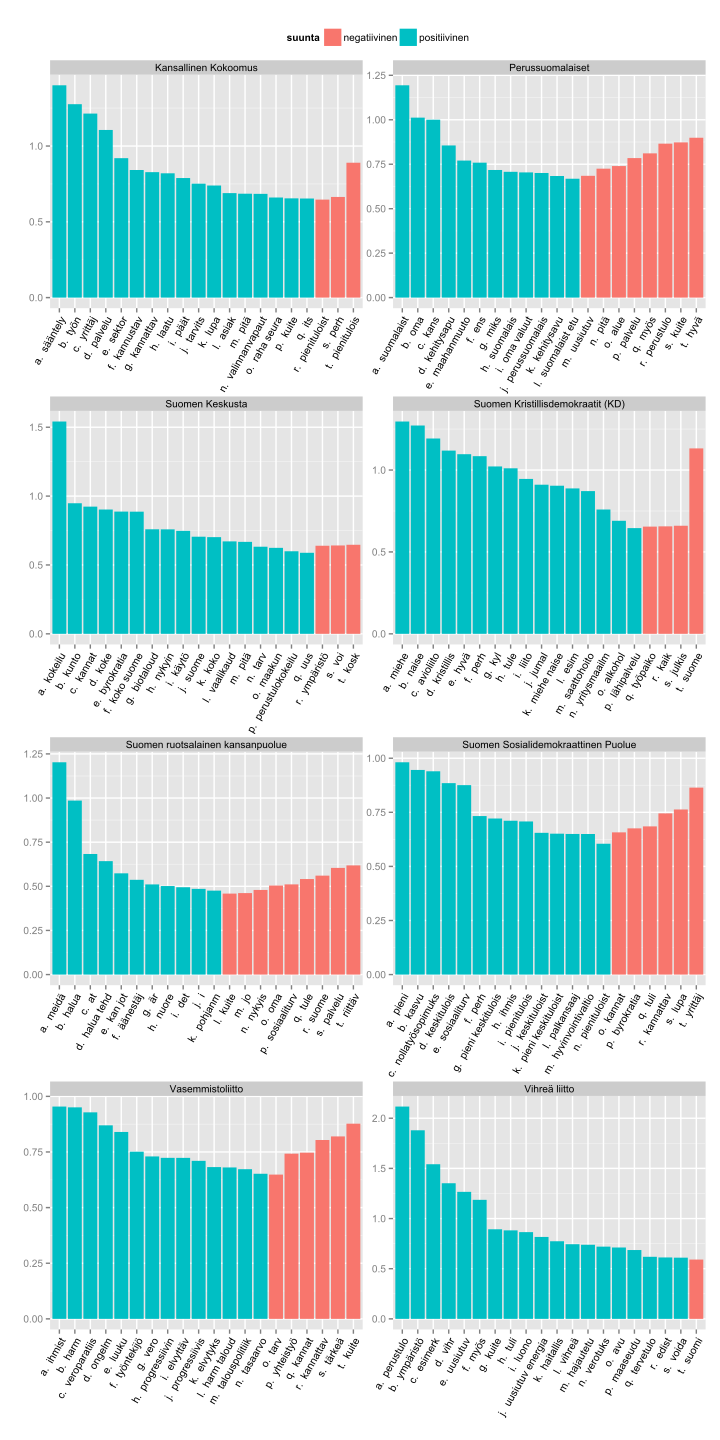

In [18]:
%%R -w 10 -h 20 -i df_out
p <- ggplot(df_out, aes(x = sana, y = absval, fill = suunta)) +
  geom_bar(stat = "identity") +
  facet_wrap(~puolue, ncol = 2, scales = "free") +
  theme(axis.text.x = element_text(size = 10, color = "black", angle = 60, hjust = 1)) +
  xlab("") + ylab("") + theme(legend.position = "top")
print(p)

Löydetyt avainsanat vaikuttavat ihan järkeviltä. Esimerkiksi Vihreiltä nousee esiin kärkiteemana perustulo, Vasemmistoliitolta harmaa talous/veroparatiisit ja  Kokoomukselta sääntely. RKP:n avainsanoista huomataan, että ruotsinkielisten havaintojen poistamisesta huolimatta jäljelle on jäänyt ruotsinkielisiä vastauksia (esim. det, är). Ehkä jotkut ovat vastanneet vaalikoneeseen molemmmilla kotimaisilla ja langdetect on mennyt tästä sekaisin.

#"Puheenjohtajatentti"
Viimeiseksi tutkitaan sitä, mihin puolueisiin luokittelumallimme laittaisivat puolueiden puheenjohtajat. Alla olevassa koodinpätkässä käydään yksitellen läpi puolueiden luokittelumallit ja ennustetaan puheenjohtajille mallin mukaiset osumatodennäköisyydet (muistetaaan, että puoluejohtajien vastaukset poimittiin aiemmin sparse-matriisiin `xtest`). Todennäköisyydet kerätään `numpy`-matriisiin.

In [19]:
mat_preds = np.zeros((len(pj_test), len(clfs_fin.keys())))
for i, puolue in enumerate(clfs_fin.keys()):
    clf = clfs_fin[puolue]
    preds = clf.predict_proba(xtest)
    mat_preds[:, i] = preds[:, 1]

Todennäköisyysmatriisi piirretään Pythonin `seaborn`-kirjaston `heatmap`-funktiolla siten, että puolueet laitetaan riveille ja puheenjohtajat sarakkeille.

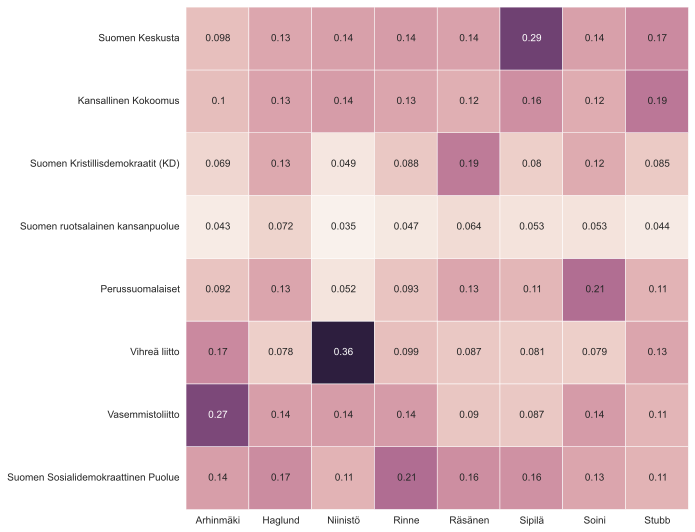

In [20]:
pylab.rcParams['figure.figsize'] = 9, 9
sns.heatmap(mat_preds.T, yticklabels = clfs_fin.keys(), xticklabels = pj_test.values, annot = True, cbar = False);

Huomataan, että puheenjohtajat soveltuvat omiin puolueisiinsa sen verran hyvin, että jokaisella puoluejohtajalla on oman puolueensa korkein osumatodennäköisyys. Lisäksi Carl Haglundia lukuunottamatta jokaisen puoluejohtajan osuvin puolue on myös heidän oma puolueensa. RKP:n lukuja on vähän vaikea verrata muihin kun osumatodennäköisyydet ovat kauttaaltaan niin pieniä.

Matriisista löytyy ihan järkeviä juttuja. Esimerkiksi Alexander Stubb sopisi lähes yhtä hyvin Keskustaan kuin Kokoomukseen (tod. 0.17 vs. 0.19), ja puolueet ajoivatkin mielestäni aika samanlaisia teemoja tämän vuoden eduskuntavaaleissa. Paavo Arhinmäki soveltuisi melko hyvin sekä Vihreisiin (0.17) että SDPhen (0.14). Myös Ville Niinistön erittäin korkea osumatodennäköisyys Vihreille (0.36) vaikuttaa järkevältä.

Toisaalta, matriisilta löytyy myös vähän outoja havaintoja. Esimerkiksi Carl Haglundin korkea soveltuvuus SDPn kanssa (0.17) yllättää. Samoin Päivi Räsäsen korkea osumatodennäköisyys SDPlle hämmentää hieman. SDPn osumaluvuissa on yleisesti merkillepantavaa se, että kaikki kahdeksan puheenjohtajaa ovat osumatodennäköisyyksissä aika lähellä toisiaan. 

Lievä pettymys on se miten alhaisiksi osumatodennäköisyydet yleisesti jäävät. Korkein yksittäinen todennäköisyys on Ville Niinistön Vihreiden osumatodennäköisyys (0.36), mutta tämäkin on aika kaukana positiivisesta luokittelusta (oletusarvona vain 0.5:n todennäköisyyden ylittävät ennustetaan positiivisiksi havainnoiksi). Vaikka mallit ovat ROC-AUC-lukujen perusteella hyviä ennustamaan osumatodennäköisyyksiä ja erottamaan positiivisia ja negatiivisia havaintoja toisistaan, ne vaatisivat kuitenkin kalibrointia jotta niistä tulisi toimivia luokittelumalleja.